In [1]:
!nvidia-smi

Mon Sep  9 17:14:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  |   00000000:09:00.0  On |                  N/A |
| 32%   33C    P8             38W /  350W |    2832MiB /  24576MiB |     27%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ['GIT_PYTHON_REFRESH'] = 'quiet'

In [3]:
from IPython.display import clear_output as clear

In [4]:
# Common
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from random import random

# Data
import tensorflow.image as tfi
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
# Model Layers
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import concatenate
from keras.layers import ZeroPadding2D
from keras.layers import Conv2DTranspose
from tensorflow_addons.layers import InstanceNormalization

# Model Functions
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.initializers import RandomNormal

# Optimizers
from tensorflow.keras.optimizers import Adam
# Loss
from keras.losses import BinaryCrossentropy

# Model Viz
from tensorflow.keras.utils import plot_model

c:\Users\x4325\anaconda3\envs\test\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\x4325\anaconda3\envs\test\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you 

In [5]:
def show_image(image, title=None):
    '''
    The function takes in an image and plots it using Matplotlib.
    '''
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [23]:
root_horse_path = 'archive/trainA'
root_zebra_path = 'archive/trainB'
horse_paths = sorted(glob(root_horse_path + '/*.jpg'))[:1000]
zebra_paths = sorted(glob(root_zebra_path + '/*.jpg'))[:1000]

In [24]:
SIZE = 256
horse_images, zebra_images = np.zeros(shape=(len(horse_paths),SIZE,SIZE,3)), np.zeros(shape=(len(horse_paths),SIZE,SIZE,3))
for i,(horse_path, zebra_path) in tqdm(enumerate(zip(horse_paths, zebra_paths)), desc='Loading'):
    
    horse_image = img_to_array(load_img(horse_path))
    horse_image = tfi.resize(tf.cast(horse_image, tf.float32)/255., (SIZE, SIZE))
    
    zebra_image = img_to_array(load_img(zebra_path))
    zebra_image = tfi.resize(tf.cast(zebra_image,tf.float32)/255., (SIZE, SIZE))
    
    # as the data is unpaired so we don't have to worry about, positioning the images.
    
    horse_images[i] = horse_image
    zebra_images[i] = zebra_image

Loading: 1000it [00:09, 108.56it/s]


In [25]:
dataset = [horse_images, zebra_images]

In [26]:
def ResidualBlock(filters, layer, index):
#     init = RandomNormal(stddev=0.02)
    
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, name="Block_{}_Conv1".format(index))(layer)
    x = InstanceNormalization(axis=-1, name="Block_{}_Normalization1".format(index))(x)
    x = ReLU(name="Block_{}_ReLU".format(index))(x)
    
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, name="Block_{}_Conv2".format(index))(x)
    x = InstanceNormalization(axis=-1, name="Block_{}_Normalization2".format(index))(x)
    
    x = concatenate([x, layer], name="Block_{}_Merge".format(index))
    
    return x

In [27]:
def downsample(filters, layer, size=3, strides=2, activation=None, index=None, norm=True):
    x = Conv2D(filters, kernel_size=size, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, name="Encoder_{}_Conv".format(index))(layer)
    if norm:
        x = InstanceNormalization(axis=-1, name="Encoder_{}_Normalization".format(index))(x)
    if activation is not None:
        x = Activation(activation, name="Encoder_{}_Activation".format(index))(x)
    else:
        x = LeakyReLU( name="Encoder_{}_LeakyReLU".format(index))(x)
    return x

In [28]:
def upsample(filters, layer, size=3, strides=2, index=None):
    x = Conv2DTranspose(filters, kernel_size=size, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, name="Decoder_{}_ConvT".format(index))(layer)
    x = InstanceNormalization(axis=-1, name="Decoder_{}_Normalization".format(index))(x)
    x = ReLU( name="Encoder_{}_ReLU".format(index))(x)
    return x

In [29]:
def Generator(n_resnet=9, name="Generator"):
    
    inp_image = Input(shape=(SIZE, SIZE, 3), name="InputImage")         # 256 x 256 x3
    
    x = downsample(64, inp_image, size=7, strides=1, index=1)           # 256 x 256 x 64
    x = downsample(128, x, index=2)                                     # 128 x 128 x 128
    x = downsample(256, x, index=3)                                     # 64 x 64 x 256
    
    for i in range(n_resnet):
        x = ResidualBlock(256, x, index=i+4)                             # (64 x 64 x 256) x n_resnet
    
    x = upsample(128, x, index=13)                                       # 128 x 128 x 128
    x = upsample(64, x, index=14)                                        # 256 x 256 x 64
    x = downsample(3, x, size=7, strides=1, activation='tanh', index=15) # 256 x 256 x 3
    
    model = Model(
        inputs=inp_image,
        outputs=x,
        name=name
    )
    return model

In [30]:
def Discriminator(name='Discriminator'):
    init = RandomNormal(stddev=0.02)
    src_img = Input(shape=(SIZE, SIZE, 3), name="InputImage")     # 256 x 256 x 3
    x = downsample(64, src_img, size=4, strides=2, index=1, norm=False) # 128 x 128 x 64
    x = downsample(128, x, size=4, strides=2, index=2)            # 64 x 64 x 128
    x = downsample(256, x, size=4, strides=2, index=3)            # 32 x 32 x 256
    x = downsample(512, x, size=4, strides=2, index=4)            # 16 x 16 x 512
    x = downsample(512, x, size=4, strides=2, index=5)            # 8 x 8 x 512  # we can try out a different architecture with zero padding layer.
    patch_out = Conv2D(1, kernel_size=4, padding='same', kernel_initializer=init, use_bias=False)(x) # 8 x 8 x 1
    
    model = Model(
        inputs=src_img,
        outputs=patch_out,
        name=name
    )
    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
        loss_weights=[0.5]
    )
    return model

In [31]:
def CombineModel(g_model1, g_model2, d_model, name):
    # train the Generator
    g_model1.trainable = True

    # Stop the Discriminator and 2nd Generator
    d_model.trainable = False
    g_model2.trainable = False
    
    # Adversarial Loss
    input_gen = Input(shape=(SIZE, SIZE, 3))
    gen_1_out = g_model1(input_gen)
    dis_out = d_model(gen_1_out)
    
    # Identity Loss
    input_id = Input(shape=(SIZE, SIZE, 3))
    output_id = g_model1(input_id)
    
    # Cycle Loss - Forward
    output_f = g_model2(gen_1_out)
    
    # Cycle Loss - Backward
    gen_2_out = g_model2(input_id)
    output_b = g_model1(gen_2_out)
     # Final Model 
    model = Model(
        inputs=[input_gen, input_id],
        outputs=[dis_out, output_id, output_f, output_b],
        name=name
    )
    model.compile(
        loss=['mse', 'mae', 'mae', 'mae'],
        loss_weights=[1,5,10,10],
        optimizer= Adam(learning_rate=2e-4, beta_1=0.5)
    )
    return model

In [32]:
def generate_real_samples(n_samples, dataset):
    ix = np.random.randint(0,dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones(shape=(n_samples, 8, 8, 1))
    return X, y

In [33]:
def generate_fake_samples(g_model, dataset):
    X = g_model.predict(dataset)
    y = np.zeros(shape=(len(dataset), 8, 8, 1))
    return X, y

In [34]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            selected.append(image)
        else:
            ix = np.random.randint(0,len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

In [35]:
def show_preds(g_AB, g_BA,n_images=1):
    for i in range(n_images):
        
        # id = np.random.randint(len(horse_images))
        if len(horse_images) == 0:
            print("Error: No images in the dataset.")
        # Add additional handling as needed
        else:
            id = np.random.randint(len(horse_images))
            horse, zebra = horse_images[id], zebra_images[id]
        horse_pred, zebra_pred = g_BA.predict(tf.expand_dims(zebra,axis=0))[0], g_AB.predict(tf.expand_dims(horse,axis=0))[0]
        
        plt.figure(figsize=(10,8))
        
        plt.subplot(1,4,1)
        show_image(horse, title='Original Horse')
        
        plt.subplot(1,4,2)
        show_image(zebra_pred, title='Generated Zebra')
        
        plt.subplot(1,4,3)
        show_image(zebra, title='Original Zebra')
        
        plt.subplot(1,4,4)
        show_image(horse_pred, title='Genrated Horse')
        
        plt.tight_layout()
        plt.show()

In [36]:
def train(d_model_A, d_model_B, gen_AB, gen_BA, c_AB, c_BA, epochs=10, chunk=5):
    
    n_epochs, n_batch = epochs, 1
    
    trainA, trainB = dataset
    poolA, poolB = list(), list()
    
    # in simple words, we are going through the whole data.
    bat_per_epoch = int(len(trainA)/n_batch)
    n_steps = bat_per_epoch
    
    for j in tqdm(range(1,epochs+1), desc="Epochs"):
        for i in range(n_steps):
            
            # Let's get some real data in hand.
            X_realA, y_realA = generate_real_samples(n_batch, trainA)
            X_realB, y_realB = generate_real_samples(n_batch, trainB)

            # use our generators to generate some fake data.
            X_fakeA, y_fakeA = generate_fake_samples(gen_BA, X_realB)
            X_fakeB, y_fakeB = generate_fake_samples(gen_AB, X_realA)
            
            # create a pool of images. You can also understand it like a replay buffer.
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolA, X_fakeB)
            
            # Let's finally train the gen 2 and get the losses.
            gen_loss2, _, _, _, _ = c_BA.train_on_batch(
                [X_realB, X_realA],
                [y_realB, X_realA, X_realB, X_realA]
            )
            
            # It's time for our discriminator to win our generator.
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            
            # one cycle is completed, let's move to second cycle.
            gen_loss1, _, _, _, _ = c_AB.train_on_batch(
                [X_realA, X_realB],
                [y_realA, X_realB, X_realA, X_realB]
            )
            
            # again, let's give some power to our discriminators.
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        if (j%chunk)==0:
            show_preds(gen_AB, gen_BA, n_images=1)
            gen_AB.save("GeneratorHtoZ.h5")
            gen_BA.save("GeneratorZtoH.h5")

In [37]:
# let's create our generators.
g_AB = Generator(name="GeneratorAB")
g_BA = Generator(name="GeneratorBA")

# here are the respective discriminators.
d_A = Discriminator(name="DiscriminatorA")
d_B = Discriminator(name="DiscriminatorB")

# finally, let's combine all of them.
c_AB = CombineModel(g_AB, g_BA, d_B, name="GanAB")
c_BA = CombineModel(g_BA, g_AB, d_A, name="GanBA")

In [38]:
# it's time to give them the superior knowledge.
train(d_A, d_B, g_AB, g_BA, c_AB, c_BA, epochs=20, chunk=5)
g_AB.save("GeneratorHtoZ2.h5")
g_BA.save("GeneratorZtoH2.h5")   

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

1/1 [==============================] - 0s 471ms/step


Epochs:   0%|          | 0/20 [01:18<?, ?it/s]


KeyboardInterrupt: 

In [39]:
HtoZ_gen = load_model("GeneratorHtoZ2.h5")
ZtoH_gen = load_model("GeneratorZtoH2.h5")

1/1 [==============================] - 1s 1s/step


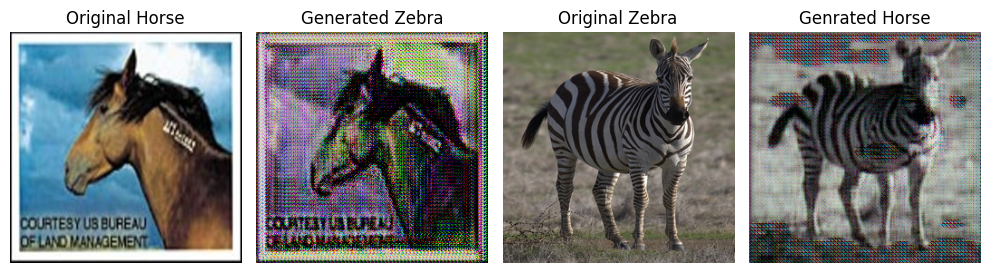

1/1 [==============================] - 0s 456ms/step


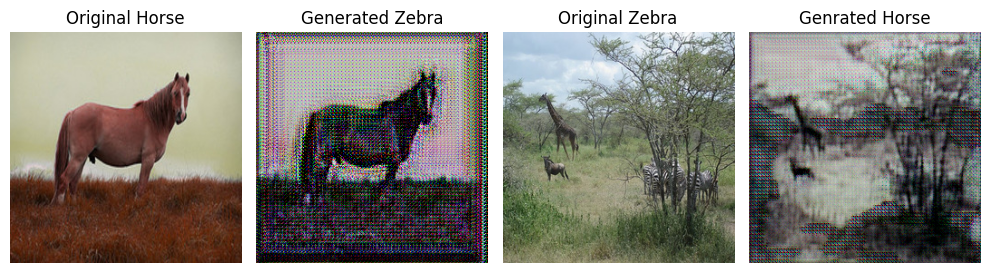

1/1 [==============================] - 0s 467ms/step


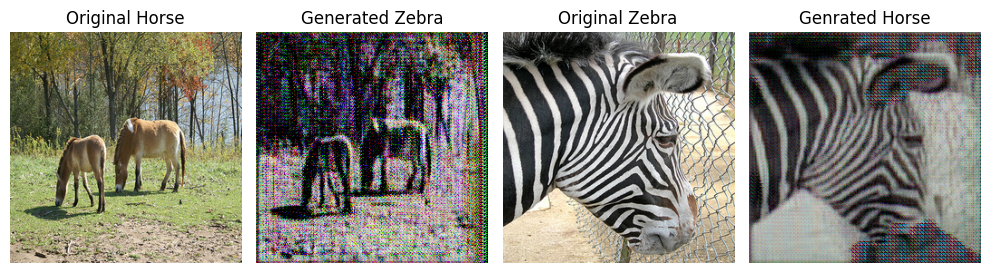

1/1 [==============================] - 0s 458ms/step


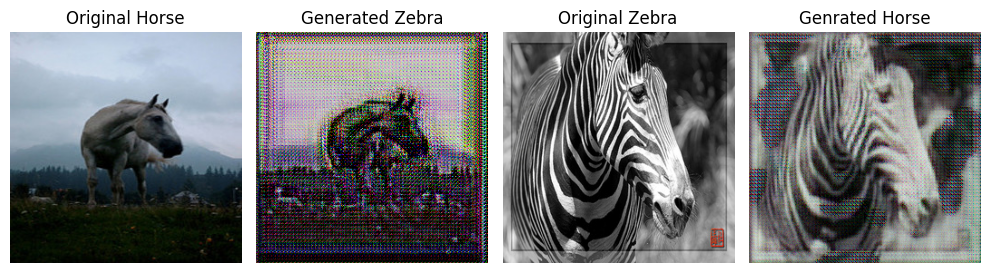

1/1 [==============================] - 0s 461ms/step


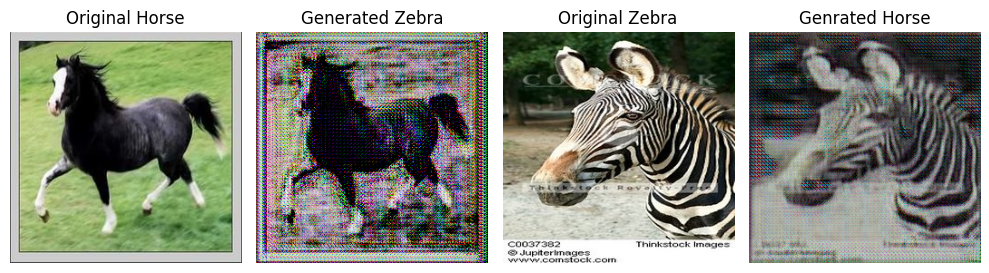

In [40]:
show_preds(HtoZ_gen, ZtoH_gen, n_images=5)